**Tutorial 8 - Markov Chain Monte Carlo**

In this tutorial we will learn how to construct a basic Metropolis-Hastings Markov Chain sampler and apply it to supernova data.


In [1]:
# 1) Make a Metropolis-Hastings stepping function.
#
# The function should take the following inputs 
# x - the current position in parameter space
# loglike - the value of the log of the likelihood 
#           evaluated at x
# loglike_func - a function that returns to log of the 
#            likelihood given a position in parameters space
# proposal_func - a proposal function that takes a position in 
#                  parameter space and proposes another
#
# The function should return the updated position, the updated 
# loglike and a boolean that is True if the proposed step was 
# accepted and False if it wasn't. 
# You can assume the proposal function is symmetric.

import pandas as pa
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand

% matplotlib inline


def MH_step (old_x, old_loglike, loglike_func, proposal_func):
    
    new_x = proposal_func(old_x)
    
    if new_x[1] < 0. or new_x[1] > 1.:    # matter density must be 0 < omegaM < 1
        trial = False
        return old_x, old_loglike, trial
        
    new_loglike = loglike_func(new_x)
        
    alpha = np.exp(new_loglike-old_loglike)
    coin = np.random.uniform(0., 1.)
    
    if alpha > 1.:
        trial = True
        return new_x, new_loglike, trial
    else:
        if coin < alpha:
            trial = True
            return new_x, new_loglike, trial
        else:
            trial = False
            return old_x, old_loglike, trial

In [2]:
# 2) Complete this code for a Gaussian proposal function class

class gaussian_transfer_function :
    
    ## This part is the constructor and 
    ## sets the internal information in the object
    # that is declared with
    # "func = gaussian_transfer_function(sigma_vector)"
    def __init__(self, sigma):
        self.n = len(sigma)
        self.s = sigma
    ##  This part defines what happens when 
    ##  you do "y = func(x)"
    ##  This should return a new point
    def __call__(self,x):
        return rand.normal(x, self.s)

In [3]:
# 3) Make a Gaussian likelihood class of the form

class LogGaussianLikelihood :
    
    def __init__(self,y_data,x_data,y_model,sigma):
        self.x = x_data
        self.y = y_data
        self.y_model = y_model
        self.s = sigma
#         store the data, model and errors in the object
#         The function y_model(params,x_data) will return the 
#         predicted value for y to be compared to y_data

    def __call__(self,params):
        return -0.5 * np.sum( ( (self.y-self.y_model(params,self.x))/self.s )**2 )
#        Using the stored data and model to calculate 
#        the log of the Gaussian likelihood and return 
#        its value.       

4) Write a function that returns the distance modulus with 
signature def mu_model(p,z). 

parameters p are 

p[0] is the absolute magnitude normalization 

p[1] is omega_matter.  

Use the library function 
astropy.cosmology.FlatLambdaCDM.luminosity_distance(z).value 
to calculate the luminosity distance.


In [4]:
import astropy.cosmology as cosmo

def mu_model (p, z):
    universe = cosmo.FlatLambdaCDM(H0=70., Om0=p[1])
    lum_dist = universe.luminosity_distance(z).value
    mu = 5.*np.log10(lum_dist) + p[0]
    return mu

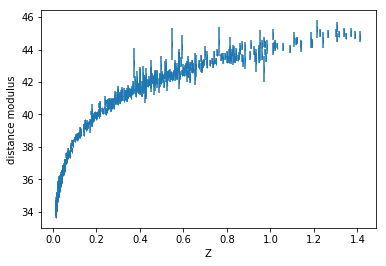

In [5]:
# Read in the supernova data
#
data = pa.read_csv("SCPUnion2.1_mu_vs_z.txt",sep='\t',comment='#')

z = data['redshift']
mu = data['dist_mod']
mu_err = data['dist_mod_error']

plt.errorbar(z,mu,yerr=mu_err,fmt='|')
plt.xlabel('Z')
plt.ylabel('distance modulus')
plt.show()

In [10]:
# 5) 
## Make an instance of LogGaussianLikelihood with the data.
## Call it loglike_func
loglike_func = LogGaussianLikelihood (mu, z, mu_model, mu_err)

## Make an instance of gaussian_transfer_function
Gtf = gaussian_transfer_function ([0.05, 0.005])

## Set up the initial point p[] and its log likelihood 
## using  loglike_func(p)
p = [25, 0.2]
p_loglike = loglike_func(p)

## Make an MCMC loop 1000 steps or more long and make a scatter plot of 
## the chain.  Record the acceptance fraction.
N_step = 10000
omegaM = np.empty(N_step)
Mag = np.empty(N_step)
hint = 0

for i in range(N_step):
    p, p_loglike, step = MH_step (p, p_loglike, loglike_func, Gtf)
    Mag[i] = p[0]
    omegaM[i] = p[1]
    if step:
        hint += 1

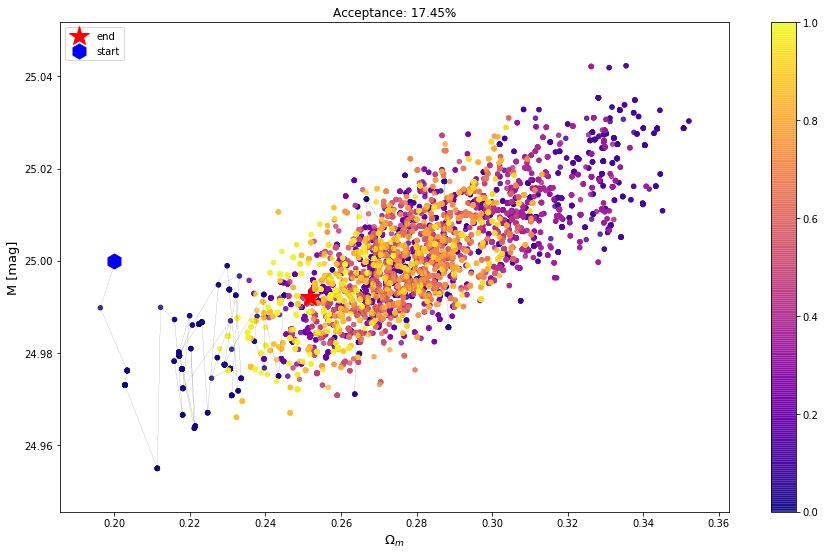

In [39]:
colors = np.linspace(0., 1., N_step)
accept = float(hint/N_step*100)

plt.figure(figsize=(15,9))
plt.scatter(omegaM, Mag, cmap='plasma', c=colors, marker='o', s=20., alpha=0.8)
plt.plot(omegaM[0:500], Mag[0:500], c='black', marker='', linewidth=0.1)
plt.plot(omegaM[-1], Mag[-1], c='red', linestyle='None', marker='*', markersize=20., label='end')
plt.plot(omegaM[0], Mag[0], c='blue', linestyle='None', marker='h', markersize=15., label='start')
plt.xlabel('$\Omega_m$', fontsize=13)
plt.ylabel('M [mag]', fontsize=13)
plt.colorbar()
plt.legend(loc='upper left')
plt.title('Acceptance: %.2f%%'% accept)
plt.show()

6) Make historgrams of the two parameters.

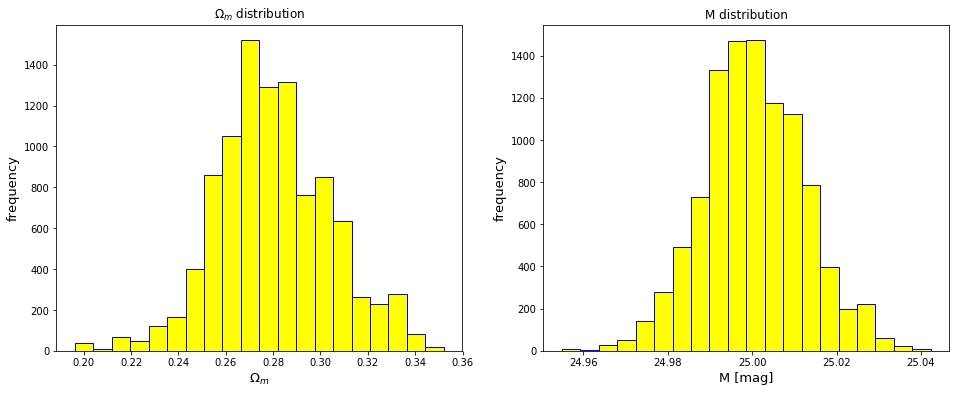

In [48]:
plt.subplots(figsize=(16,6))

plt.subplot(121)
plt.hist(omegaM, bins=20, edgecolor='blue', color='yellow')
plt.xlabel('$\Omega_m$', fontsize=13)
plt.ylabel('frequency', fontsize=13)
plt.title('$\Omega_m$ distribution')

plt.subplot(122)
plt.hist(Mag, bins=20, edgecolor='blue', color='yellow')
plt.xlabel('M [mag]', fontsize=13)
plt.ylabel('frequency', fontsize=13)
plt.title('M distribution')

plt.show()

7) Use numpy.histogram2d() to make a 2 dimensional of the chain.

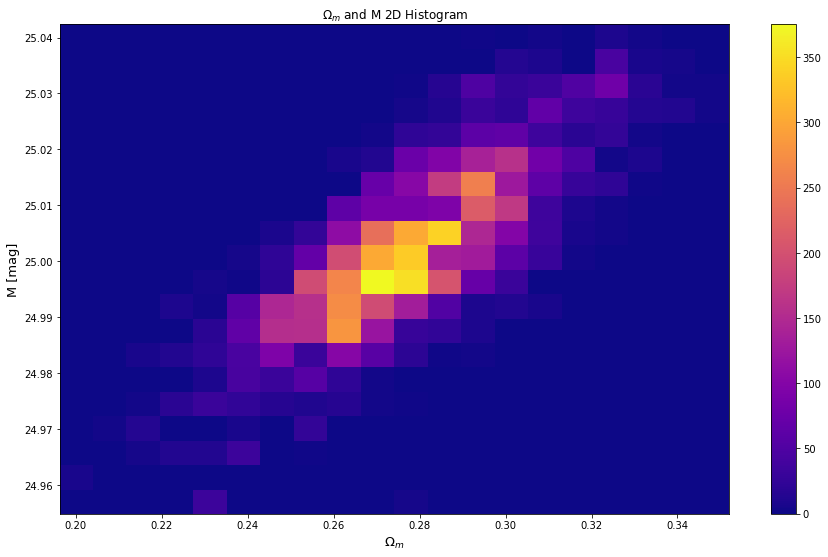

In [51]:
H, xedges, yedges = np.histogram2d(omegaM, Mag, bins=(20,20))
X, Y = np.meshgrid(xedges, yedges)

plt.figure(figsize=(15,9))
plt.pcolormesh(X, Y, H, cmap='plasma')
plt.xlabel('$\Omega_m$', fontsize=13)
plt.ylabel('M [mag]', fontsize=13)
plt.colorbar()
plt.title('$\Omega_m$ and M 2D Histogram')
plt.show()

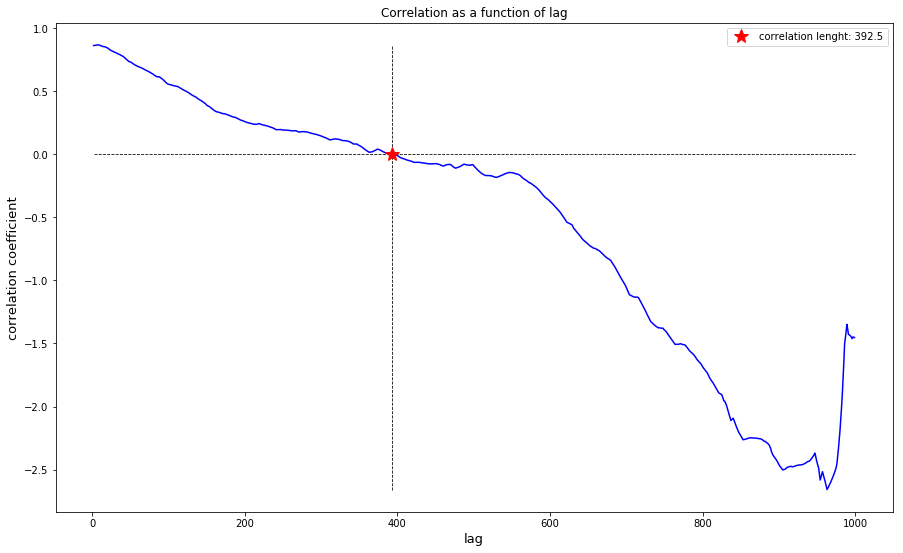

In [105]:
## 8) Use this function to estimate the correlation length 
## of your chain. Plot the autocorrelation function for 
## lag zero to a few hundred.
def corrfunction(x,y):
    '''
    This function calculates the correlation coefficient 
    as a function of lag between 
    '''
    xc = x - np.mean(x)
    yc = y - np.mean(y)
    
    N = len(x)
    out = np.empty(N-2)
    stdx = np.std(xc)
    stdy = np.std(yc)

    for i in range(N-2) :
        xt = xc[0:N-i]
        yt = yc[i:N]
        if(stdx == 0 or stdy == 0):  ## this can happen for last elements
            out[i] = 0
        else :
            out[i] = np.mean(xt*yt)/stdx/stdy

    return out

N_lag = int(N_step/10)

lag = range(2, N_lag)
corr_co = corrfunction(omegaM[:N_lag], Mag[:N_lag])
zeros = np.zeros(len(lag))

first_sign = np.sign(corr_co[0])
sign = first_sign
pivot = 0
while sign==first_sign :
    sign = np.sign(corr_co[pivot])
    pivot += 1
corr_len = (2*pivot-1)/2.
sbar = [np.min(corr_co), np.max(corr_co)]

plt.figure(figsize=(15,9))
plt.plot(lag, corr_co, color='blue')
plt.plot(lag, zeros, color='black', linestyle='--', linewidth=0.8)
plt.plot([corr_len, corr_len], sbar, color='black', linestyle='--', linewidth=0.8)
plt.plot(corr_len, 0, marker='*', markersize=15, linestyle='None', color='red', label='correlation lenght: %.1f' % corr_len)
plt.xlabel('lag', fontsize=13)
plt.ylabel('correlation coefficient', fontsize=13)
plt.title('Correlation as a function of lag')
plt.legend()
plt.show()

8) Calculate the mean, variance and covariance of the parameters.

In [128]:
mean_omegaM = np.mean(omegaM)
var_omegaM = np.var(omegaM)

mean_Mag = np.mean(Mag)
var_Mag = np.var(Mag)

par_cov = np.cov(omegaM, Mag)

print('$\Omega_m$ = %.3f +/- %.3f' % (mean_omegaM, np.sqrt(var_omegaM)))
print('M = %.3f +/- %.3f' % (mean_Mag, np.sqrt(var_Mag)))
print('The covariance matrix is :')
print(par_cov)

$\Omega_m$ = 0.280 +/- 0.024
M = 25.000 +/- 0.012
The covariance matrix is :
[[0.00057963 0.00022742]
 [0.00022742 0.00014264]]
